# Introduction

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.

Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. 

Check the F1 for the test set.

Additionally, measure the AUC-ROC metric and compare it with the F1.

### Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve 
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


# EDA

Description of the Dataset
- RowNumber — Index
- CustomerId — Unique customer identifier
- Surname — Customer's Last Name
- CreditScore — Customer's credit score
- Geography — Customer's country of residence
- Gender — Customer's gender
- Age — Customer's age
- Tenure — How long the customer has been banking with bank
- Balance — Customer's account balance
- NumOfProducts —  Number of total banking products used by  customer
- HasCrCard — If customer has a credit card
- IsActiveMember — If Customer is an active bank member
- EstimatedSalary — Customer's estimated salary
- Exited — Customer left bank


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


# Checking for Null Values

In [4]:
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
data['Tenure']= data['Tenure'].fillna(0)
data['Tenure'] = data['Tenure'].astype(int)

We will fill the tenure n/a values with 0 and change the datatype to int64. 

In [6]:
data = data.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

We will drop columns that could potentially have a negative influence on the models.

## Regression Preprocessing

In [7]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Splitting Data

In [8]:
df_train, df_rest = train_test_split(data_ohe, test_size=0.40, random_state=12345)
df_valid, df_test = train_test_split(df_rest, test_size=0.50, random_state=12345)

In [9]:
features_train_reg = df_train.drop(['Exited'], axis=1)
target_train_reg = df_train['Exited']
features_valid_reg = df_valid.drop(['Exited'], axis=1)
target_valid_reg = df_valid['Exited']
features_test_reg = df_test.drop(['Exited'], axis=1)
target_test_reg = df_test['Exited']

Standartizing numeric features 

In [10]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train_reg[numeric])
features_train_reg[numeric] = scaler.transform(features_train_reg[numeric])
features_valid_reg[numeric] = scaler.transform(features_valid_reg[numeric])
features_test_reg[numeric] = scaler.transform(features_test_reg[numeric])
features_train_reg.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0


## Tree Preprocessing

In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [12]:
encoder = LabelEncoder()
data["Geography"] = pd.DataFrame(encoder.fit_transform(data["Geography"]))
data["Gender"] = pd.DataFrame(encoder.fit_transform(data["Gender"]))

In [13]:
df_train, df_rest = train_test_split(data, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_rest, test_size=0.5, random_state=12345)

In [14]:
features_train_tree = df_train.drop(['Exited'], axis=1)
target_train_tree = df_train['Exited']
features_valid_tree = df_valid.drop(['Exited'], axis=1)
target_valid_tree = df_valid['Exited']
features_test_tree = df_test.drop(['Exited'], axis=1)
target_test_tree = df_test['Exited']

In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train_tree[numeric])
features_train_tree[numeric] = scaler.transform(features_train_tree[numeric])
features_valid_tree[numeric] = scaler.transform(features_valid_tree[numeric])
features_test_tree[numeric] = scaler.transform(features_test_tree[numeric])
features_train_tree.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,-0.886751,2,1,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705
3411,0.608663,0,0,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945
6027,2.052152,1,1,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095
1247,-1.457915,0,1,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061
3716,0.130961,1,0,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268


## Class Balances

0    0.7963
1    0.2037
Name: Exited, dtype: float64


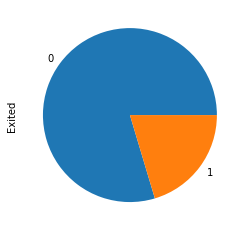

In [16]:
class_frequency = data['Exited'].value_counts(normalize= True)
print(class_frequency)
class_frequency.plot(kind='pie')
plt.show()

The pie graph shows the distribution of current and exited customers. It shows that just under 80% of customers are active.




### Logistic Regression

In [25]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_reg, target_train_reg)
predicted_valid = model.predict(features_valid_reg)
print ('Model accuracy:' , model.score(features_valid_reg, target_valid_reg ))
print('F1:', f1_score(target_valid_reg, predicted_valid))

probabilities_valid = model.predict_proba(features_valid_reg)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_reg, probabilities_one_valid)

print('ROC-AUC:', auc_roc)

Model accuracy: 0.8025
F1: 0.33389544688026984
ROC-AUC: 0.7586317967081824


The Logistic Regression model's accuracy is 80%. It's F1 score comes in at 0.33.

### Decision Tree

In [20]:
model =  DecisionTreeClassifier(random_state = 12345, max_depth = 7)

model.fit(features_train_tree, target_train_tree)
predicted_valid = model.predict(features_valid_tree)


print('Model accuracy:' , accuracy_score(target_valid_tree, predicted_valid) )
print('F1:', f1_score(target_valid_tree, predicted_valid))

probabilities_valid = model.predict_proba(features_valid_tree)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_tree, probabilities_one_valid)


print('ROC-AUC:', auc_roc)

Model accuracy: 0.8505
F1: 0.5106382978723405
ROC-AUC: 0.8013287946334057


The Decision Tree model's accuracy is 83%. It's F1 score comes in at 0.51.

### Random Tree

In [27]:
model = RandomForestClassifier(random_state=12345, n_estimators= 250) # set number of trees
model.fit(features_train_tree,target_train_tree ) # train model on training set
predicted_valid = model.predict(features_valid_tree)
accuracy_valid = accuracy_score(target_valid_tree, predicted_valid)
print('Model accuracy:' , accuracy_score(target_valid_tree, predicted_valid) )
print('F1:', f1_score(target_valid_tree, predicted_valid))

Model accuracy: 0.8535
F1: 0.5593984962406016


The Random Tree model's accuracy is 85%. It's F1 score comes in at 0.56.

The Random Tree model's accuracy and F1 score are higher than the other model's so we will continue with it.

In [28]:
probabilities_valid = model.predict_proba(features_valid_tree)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_tree, probabilities_one_valid)

print(auc_roc)

0.8399072399421723


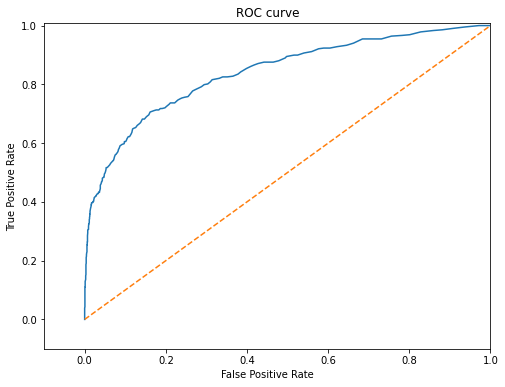

In [29]:
fpr, tpr, thresholds = roc_curve(target_valid_tree, probabilities_one_valid)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Class Inbalance

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train_tree, target_train_tree, 5
)

features_valid_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8532 to 6895
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      2000 non-null   float64
 1   Geography        2000 non-null   int64  
 2   Gender           2000 non-null   int64  
 3   Age              2000 non-null   float64
 4   Tenure           2000 non-null   float64
 5   Balance          2000 non-null   float64
 6   NumOfProducts    2000 non-null   float64
 7   HasCrCard        2000 non-null   int64  
 8   IsActiveMember   2000 non-null   int64  
 9   EstimatedSalary  2000 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 171.9 KB


In [31]:
model = RandomForestClassifier(random_state=12345, n_estimators= 250) 
model.fit(features_upsampled,target_upsampled ) 
predicted_valid = model.predict(features_valid_tree)
print('F1:', f1_score(target_valid_tree, predicted_valid))

F1: 0.6018641810918776


In [32]:
probabilities_valid = model.predict_proba(features_valid_tree)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_tree, probabilities_one_valid)

print(auc_roc)

0.8383738408773342


Upsampling got us to the target F1 value 0.60. AUC-ROC score slightly dropped to 0.83

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train_tree, target_train_tree, 0.2
)

In [34]:
model = RandomForestClassifier(random_state=12345, n_estimators= 250) 
model.fit(features_downsampled,target_downsampled ) 
predicted_valid = model.predict(features_valid_tree)
print('F1:', f1_score(target_valid_tree, predicted_valid))

F1: 0.5575447570332481


In [35]:
probabilities_valid = model.predict_proba(features_valid_tree)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_tree, probabilities_one_valid)

print(auc_roc)

0.8425075157725368


Downsampling took us below the target F1 value 0.59. AUC-ROC score stayed the same at 0.84

### Final Model Test

In [38]:
model = RandomForestClassifier(random_state=12345, n_estimators= 250) 
model.fit(features_upsampled,target_upsampled ) 
predicted_valid = model.predict(features_test_tree)
print('Model accuracy:' , accuracy_score(target_test_tree, predicted_valid) )
print('F1:', f1_score(target_test_tree, predicted_valid))

probabilities_valid = model.predict_proba(features_valid_tree)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_tree, probabilities_one_valid)

print('ROC-AUC:', auc_roc)

Model accuracy: 0.845
F1: 0.5942408376963351
ROC-AUC: 0.8383738408773342


## Conclusion

Multiple things were done in completing this project. First, we loaded necessary libraries and performed EDA on the dataset.
We then begin to work on the data preprocessing for the models. It has to be done twice, once for Regression and another for the Tree (Decision & Random) models. After trial and error we got to the .59 target necessary for the project. We achieved this by using the Random Forest. 